## 1. Repositório de dados:
https://github.com/cmmonteforte/Grupo9-ProjetoAplicadoIV

## 2. Base de dados:
https://covid.saude.gov.br/

## 3. Objetivo

Neste projeto, buscamos desenvolver um modelo preditivo que analise dados históricos de casos e óbitos causados pela COVID-19 no território brasileiro, tentando prever a quantidade de novos casos para que assim seja possível apoiar a tomada de decisão das autoridades na gestão de saúde pública.

Esperamos atingir esse objetivo através das seguintes metas:

* Coletar e processar dados oficiais de casos e óbitos relacionados à COVID-19 no Brasil;
* Aplicar e comparar técnicas de modeloagem de séries temporais;
* Validar o desempenho dos modelos preditivos através de métricas de erros e testes estatísticos;
* Gerar um modelo com bom desempenho, capaz de prever a quantidade de casos ou óbitos nos próximos dias, semanas ou meses.

## 4. Definição dos pacotes

In [3]:
#Importando os pacotes
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prettytable import PrettyTable
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import prophet
import statsmodels.api as sm


%matplotlib inline
sns.set_style('darkgrid')

## 5. Geração da tabela de Metadados



In [4]:
df = pd.read_csv("df_covid.csv")
df.head()

,regiao,estado,municipio,coduf,codmun,codRegiaoSaude,nomeRegiaoSaude,data,semanaEpi,populacaoTCU2019,casosAcumulado,casosNovos,obitosAcumulado,obitosNovos,Recuperadosnovos,emAcompanhamentoNovos,interior/metropolitana
0,Brasil,NaN,NaN,76,NaN,NaN,NaN,2021-07-01,26,210147125.0,18622304.0,65163,520095,2029,16858632.0,1180443.0,NaN
1,Brasil,NaN,NaN,76,NaN,NaN,NaN,2021-07-02,26,210147125.0,18687469.0,65165,521952,1857,16931272.0,1170937.0,NaN
2,Brasil,NaN,NaN,76,NaN,NaN,NaN,2021-07-03,26,210147125.0,18742025.0,54556,523587,1635,16989351.0,1176166.0,NaN
3,Brasil,NaN,NaN,76,NaN,NaN,NaN,2021-07-04,27,210147125.0,18769808.0,27783,524417,830,17033808.0,1184630.0,NaN
4,Brasil,NaN,NaN,76,NaN,NaN,NaN,2021-07-05,27,210147125.0,18792511.0,22703,525112,695,17082876.0,1162515.0,NaN


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10081354 entries, 0 to 10081353
Data columns (total 17 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   regiao                  object 
 1   estado                  object 
 2   municipio               object 
 3   coduf                   int64  
 4   codmun                  float64
 5   codRegiaoSaude          float64
 6   nomeRegiaoSaude         object 
 7   data                    object 
 8   semanaEpi               int64  
 9   populacaoTCU2019        float64
 10  casosAcumulado          float64
 11  casosNovos              int64  
 12  obitosAcumulado         int64  
 13  obitosNovos             int64  
 14  Recuperadosnovos        float64
 15  emAcompanhamentoNovos   float64
 16  interior/metropolitana  float64
dtypes: float64(7), int64(5), object(5)
memory usage: 1.3+ GB


### 5.1 Tabela com os metadados

In [6]:
# extrair nome das colunas
nomes_colunas = df.columns.tolist()

# extrair tipos de dados
tipos_dados = df.dtypes.tolist()

# extrair número de valores nulos
num_nulos = df.isnull().sum().tolist()

# criar lista com exemplos de valores não nulos e origem dos dados
exemplos = []
for coluna in nomes_colunas:
    exemplo = df[coluna].dropna().iloc[0]  # pega o primeiro valor não nulo
    exemplos.append(exemplo)

# origem dos dados
origem = ['df_covid'] * len(nomes_colunas)

# criar a tabela PrettyTable
table = PrettyTable()

# Definir os nomes das colunas
table.field_names = ["Variável", "Tipo", "Exemplo", "% Nulos", "Origem"]

# Adicionar as linhas na tabela
for i in range(len(nomes_colunas)):
    table.add_row([nomes_colunas[i], tipos_dados[i], exemplos[i], 
                  f"{round((num_nulos[i] / df.shape[0]) * 100, 2)}%", origem[i]])

# Exibir
print(table)

+------------------------+---------+-----------------------+---------+----------+
|        Variável        |   Tipo  |        Exemplo        | % Nulos |  Origem  |
+------------------------+---------+-----------------------+---------+----------+
|         regiao         |  object |         Brasil        |   0.0%  | df_covid |
|         estado         |  object |           RO          |  0.02%  | df_covid |
|       municipio        |  object | Alta Floresta D'Oeste |  0.88%  | df_covid |
|         coduf          |  int64  |           76          |   0.0%  | df_covid |
|         codmun         | float64 |        110000.0       |  0.51%  | df_covid |
|     codRegiaoSaude     | float64 |        11005.0        |  0.88%  | df_covid |
|    nomeRegiaoSaude     |  object |      ZONA DA MATA     |  0.88%  | df_covid |
|          data          |  object |       2021-07-01      |   0.0%  | df_covid |
|       semanaEpi        |  int64  |           26          |   0.0%  | df_covid |
|    populacaoTC

In [7]:
# Resumo estatístico
describe_stats = df.describe()
print("\nResumo Estatístico:")
print(describe_stats)



Resumo Estatístico:
              coduf        codmun  codRegiaoSaude     semanaEpi  \
count  1.008135e+07  1.003025e+07    9.992580e+06  1.008135e+07   
mean   3.236025e+01  3.252580e+05    3.240312e+04  2.688938e+01   
std    9.873899e+00  9.853503e+04    9.836342e+03  1.505262e+01   
min    1.100000e+01  1.100000e+05    1.100100e+04  1.000000e+00   
25%    2.500000e+01  2.512000e+05    2.501000e+04  1.400000e+01   
50%    3.100000e+01  3.146100e+05    3.105900e+04  2.700000e+01   
75%    4.100000e+01  4.119150e+05    4.101500e+04  4.000000e+01   
max    7.600000e+01  5.300100e+05    5.300100e+04  5.300000e+01   

       populacaoTCU2019  casosAcumulado    casosNovos  obitosAcumulado  \
count      1.004368e+07    1.008135e+07  1.008135e+07     1.008135e+07   
mean       1.139066e+05    1.448174e+04  1.166631e+01     2.963992e+02   
std        2.960280e+06    4.188451e+05  2.288801e+03     8.451936e+03   
min        7.810000e+02    0.000000e+00 -1.412689e+06     0.000000e+00   
25%  

## 6. Tratamento de nulos

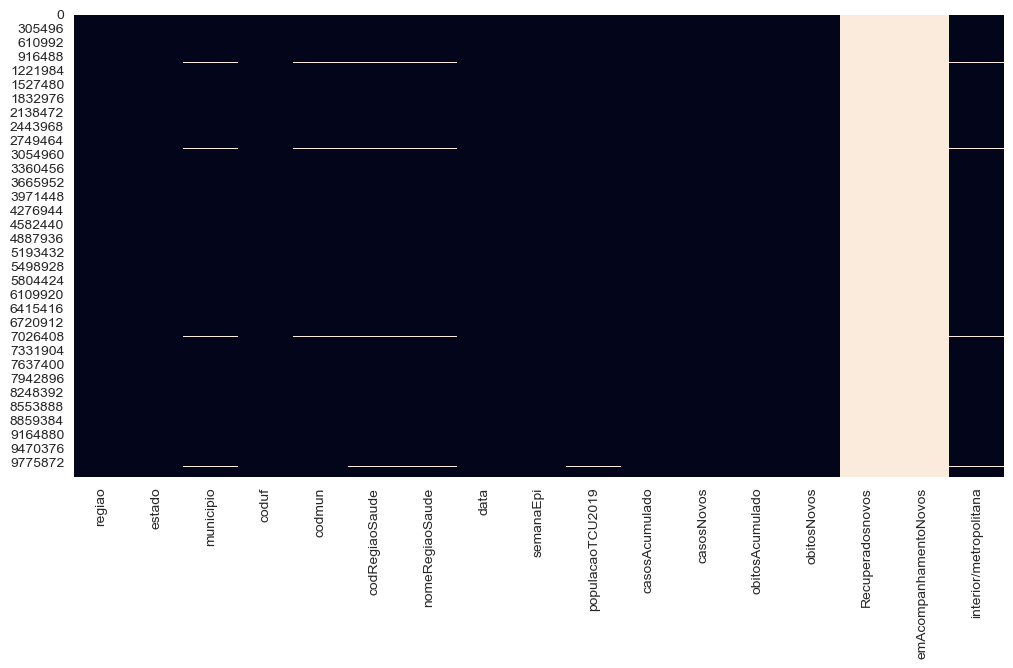

In [8]:
plt.figure(figsize=(12,6))
sns.heatmap(df.isnull(), cbar=False)
plt.show()

In [9]:
# remover colunas irrelevantes pra análise
df.drop(columns=["Recuperadosnovos", "emAcompanhamentoNovos"], inplace=True)

## 7 Análise Explorátoria

### 7.1 Preparação dos dados

In [10]:
# Converter a coluna de data para formato datetime, tratando erros
df["data"] = pd.to_datetime(df["data"], errors='coerce')

# Remover linhas com datas inválidas
df = df.dropna(subset=["data"])

# Ordenar os dados por data
df = df.sort_values(by="data")

# Agregar os dados por trimestre para melhor visualização
df["trimestre"] = df["data"].dt.to_period("Q")
df_trimestral = df.groupby("trimestre")[["casosNovos", "obitosNovos", "casosAcumulado", "obitosAcumulado"]].sum().reset_index()
df_trimestral["trimestre"] = df_trimestral["trimestre"].astype(str)

# Calcular taxa de letalidade por trimestre
df_trimestral["taxa_letalidade"] = (df_trimestral["obitosAcumulado"] / df_trimestral["casosAcumulado"]) * 100

# Calcular variação percentual de casos e óbitos entre trimestres
df_trimestral["variacao_casos"] = df_trimestral["casosNovos"].pct_change() * 100
df_trimestral["variacao_obitos"] = df_trimestral["obitosNovos"].pct_change() * 100

### 7.2 Visualização de dados

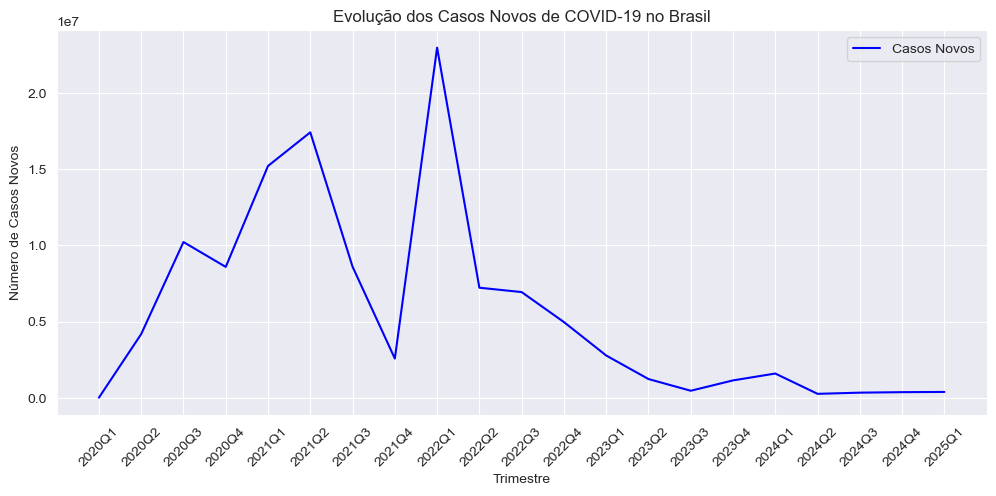

In [11]:
# Plotar evolução dos casos novos por trimestre
plt.figure(figsize=(12, 5))
plt.plot(df_trimestral["trimestre"], df_trimestral["casosNovos"], label="Casos Novos", color="blue")
plt.xlabel("Trimestre")
plt.ylabel("Número de Casos Novos")
plt.title("Evolução dos Casos Novos de COVID-19 no Brasil")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

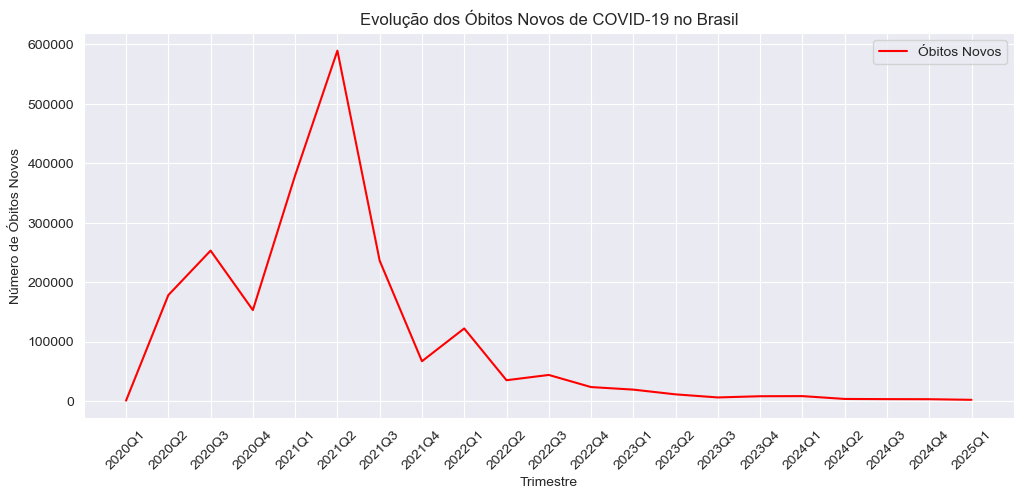

In [12]:
# Plotar evolução dos óbitos novos por trimestre
plt.figure(figsize=(12, 5))
plt.plot(df_trimestral["trimestre"], df_trimestral["obitosNovos"], label="Óbitos Novos", color="red")
plt.xlabel("Trimestre")
plt.ylabel("Número de Óbitos Novos")
plt.title("Evolução dos Óbitos Novos de COVID-19 no Brasil")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

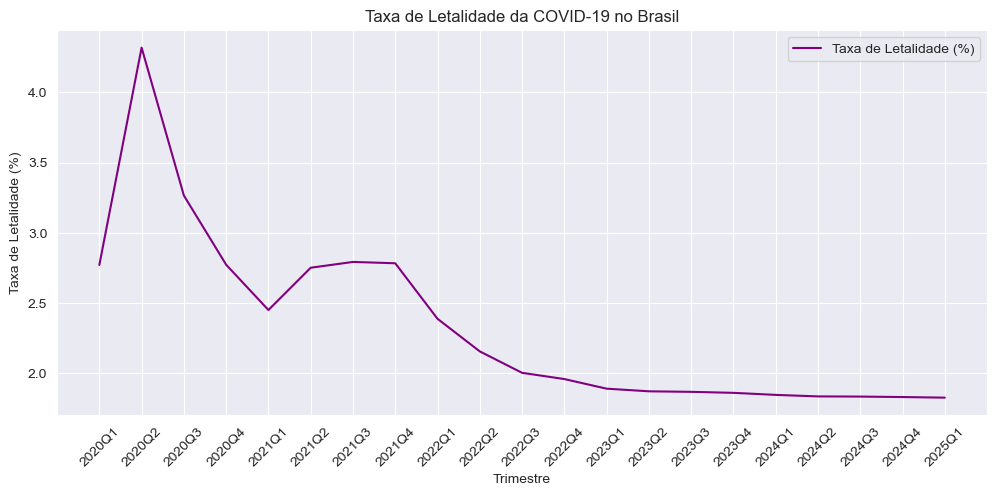

In [13]:
# Plotar taxa de letalidade
plt.figure(figsize=(12, 5))
plt.plot(df_trimestral["trimestre"], df_trimestral["taxa_letalidade"], label="Taxa de Letalidade (%)", color="purple")
plt.xlabel("Trimestre")
plt.ylabel("Taxa de Letalidade (%)")
plt.title("Taxa de Letalidade da COVID-19 no Brasil")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

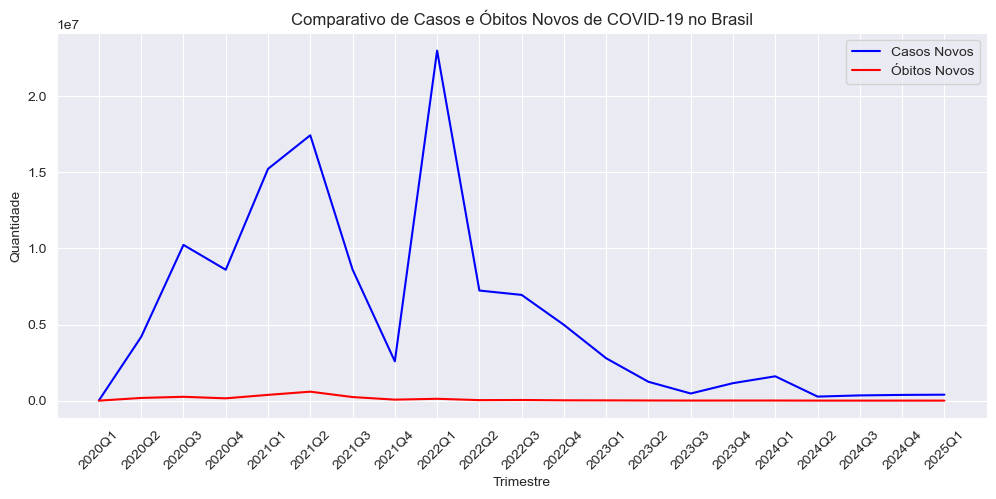

In [14]:
0# Comparar casos novos e óbitos novos no mesmo gráfico
plt.figure(figsize=(12, 5))
plt.plot(df_trimestral["trimestre"], df_trimestral["casosNovos"], label="Casos Novos", color="blue")
plt.plot(df_trimestral["trimestre"], df_trimestral["obitosNovos"], label="Óbitos Novos", color="red")
plt.xlabel("Trimestre")
plt.ylabel("Quantidade")
plt.title("Comparativo de Casos e Óbitos Novos de COVID-19 no Brasil")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


## 8 Modelagem

### 8.1 Modelo de previsão ARIMA

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MAE: 8568625.03
MSE: 91566632632763.84
RMSE: 9569045.54
MAPE: 1458.49%


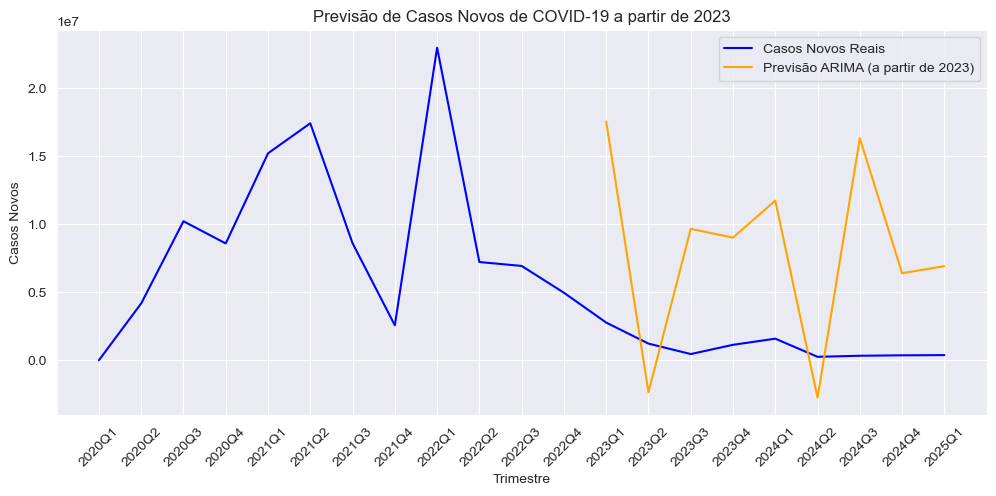

In [15]:
# Converter trimestre para datetime correspondente ao início do trimestre
df_trimestral["trimestre_dt"] = pd.PeriodIndex(df_trimestral["trimestre"], freq="Q").to_timestamp()

# Separar dados: treino antes de 2023, teste a partir de 2023
train = df_trimestral[df_trimestral["trimestre_dt"] < "2023-01-01"]["casosNovos"]
test = df_trimestral[df_trimestral["trimestre_dt"] >= "2023-01-01"]["casosNovos"]
test_index = df_trimestral[df_trimestral["trimestre_dt"] >= "2023-01-01"]["trimestre"]

# Treinar o modelo ARIMA
model = ARIMA(train, order=(5, 1, 0))
model_fit = model.fit()
forecast_arima = model_fit.forecast(steps=len(test))

# Avaliação
mae = mean_absolute_error(test, forecast_arima)
mse = mean_squared_error(test, forecast_arima)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((test - forecast_arima) / test)) * 100

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

# Plotar previsões
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(df_trimestral["trimestre"], df_trimestral["casosNovos"], label="Casos Novos Reais", color="blue")
plt.plot(test_index, forecast_arima, label="Previsão ARIMA (a partir de 2023)", color="orange")
plt.xlabel("Trimestre")
plt.ylabel("Casos Novos")
plt.title("Previsão de Casos Novos de COVID-19 a partir de 2023")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()



### 8.2 Modelo de previsão Prophet

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
11:52:11 - cmdstanpy - INFO - Chain [1] start processing
11:52:11 - cmdstanpy - INFO - Chain [1] done processing



Avaliação do modelo ARIMA:
MAE: 8568625.03
MSE: 91566632632763.84
RMSE: 9569045.54
MAPE: 1458.49%

Avaliação do modelo Prophet:
MAE: 2211230.40
MSE: 8872718319286.55
RMSE: 2978710.85
MAPE: 387.86%


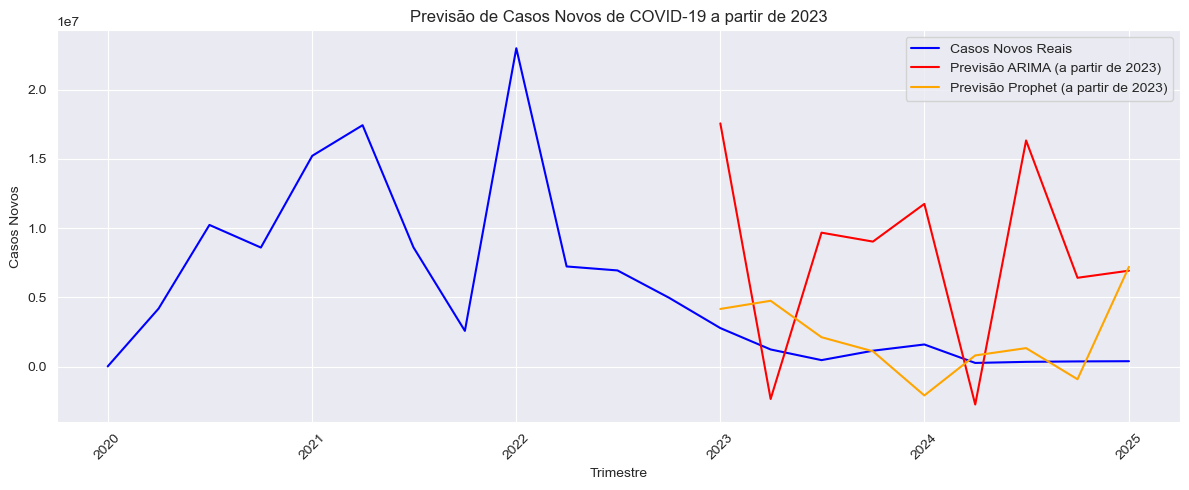

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet

#  Converter trimestre para datetime correspondente ao início do trimestre
df_trimestral["trimestre_dt"] = pd.PeriodIndex(df_trimestral["trimestre"], freq="Q").to_timestamp()

#  Separar treino e teste
train_arima = df_trimestral[df_trimestral["trimestre_dt"] < "2023-01-01"]["casosNovos"]
test_arima = df_trimestral[df_trimestral["trimestre_dt"] >= "2023-01-01"]["casosNovos"]
test_index = df_trimestral[df_trimestral["trimestre_dt"] >= "2023-01-01"]["trimestre"]

# Modelo ARIMA
model_arima = ARIMA(train_arima, order=(5, 1, 0))
model_fit = model_arima.fit()
forecast_arima = model_fit.forecast(steps=len(test_arima))

#  Avaliação ARIMA
mae_arima = mean_absolute_error(test_arima, forecast_arima)
mse_arima = mean_squared_error(test_arima, forecast_arima)
rmse_arima = np.sqrt(mse_arima)
mape_arima = np.mean(np.abs((test_arima - forecast_arima) / test_arima)) * 100

print("\nAvaliação do modelo ARIMA:")
print(f"MAE: {mae_arima:.2f}")
print(f"MSE: {mse_arima:.2f}")
print(f"RMSE: {rmse_arima:.2f}")
print(f"MAPE: {mape_arima:.2f}%")

#  Prophet – preparação
df_prophet = df_trimestral[["trimestre_dt", "casosNovos"]].rename(columns={"trimestre_dt": "ds", "casosNovos": "y"})

model_prophet = Prophet()
model_prophet.fit(df_prophet)

#  Gerar previsões futuras
future = model_prophet.make_future_dataframe(periods=4, freq="Q")
forecast = model_prophet.predict(future)

#  Preparar base de teste (a partir de 2023)
test_prophet = df_prophet[df_prophet["ds"] >= "2023-01-01"]

#  Alinhar previsões do Prophet com a base de teste
forecast_merged = pd.merge(
    test_prophet[["ds", "y"]],
    forecast[["ds", "yhat"]],
    on="ds",
    how="inner"
)

y_true_prophet = forecast_merged["y"].values
y_pred_prophet = forecast_merged["yhat"].values

#  Avaliação Prophet
mae_prophet = mean_absolute_error(y_true_prophet, y_pred_prophet)
mse_prophet = mean_squared_error(y_true_prophet, y_pred_prophet)
rmse_prophet = np.sqrt(mse_prophet)
mape_prophet = np.mean(np.abs((y_true_prophet - y_pred_prophet) / y_true_prophet)) * 100

print("\nAvaliação do modelo Prophet:")
print(f"MAE: {mae_prophet:.2f}")
print(f"MSE: {mse_prophet:.2f}")
print(f"RMSE: {rmse_prophet:.2f}")
print(f"MAPE: {mape_prophet:.2f}%")

#  Plotagem dos resultados
plt.figure(figsize=(12, 5))
plt.plot(df_trimestral["trimestre"], df_trimestral["casosNovos"], label="Casos Novos Reais", color="blue")
plt.plot(test_index, forecast_arima, label="Previsão ARIMA (a partir de 2023)", color="red")

# Previsão Prophet: converter datas de volta para o eixo original (trimestre)
prophet_plot_index = df_trimestral[df_trimestral["trimestre_dt"] >= "2023-01-01"]["trimestre"]
plt.plot(prophet_plot_index, y_pred_prophet, label="Previsão Prophet (a partir de 2023)", color="orange")

plt.xlabel("Trimestre")
plt.ylabel("Casos Novos")
plt.title("Previsão de Casos Novos de COVID-19 a partir de 2023")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()



### 8.3 Modelo de previsão AUTO-ARIMA

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=425.287, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=420.028, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=424.907, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=420.880, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=420.074, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=421.984, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=415.907, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=413.779, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=416.529, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.02 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.220 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   12
Model:         

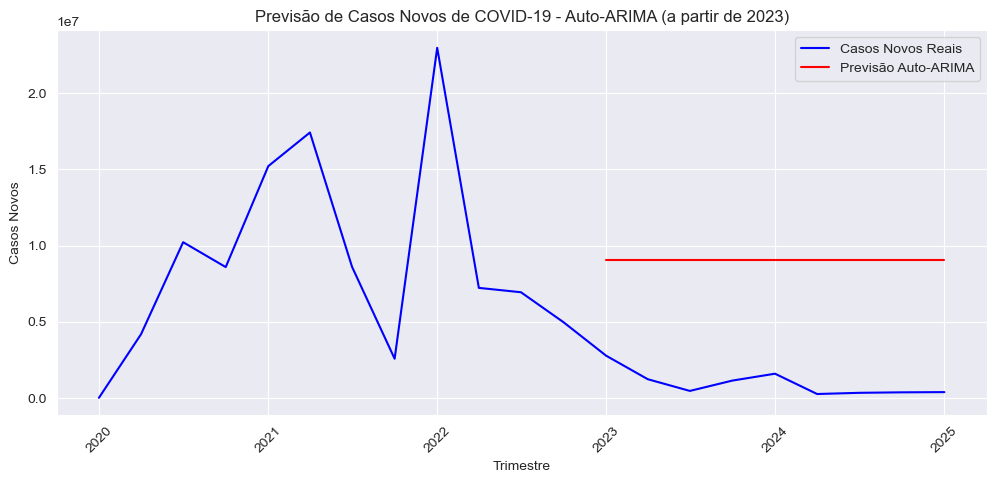

In [20]:
# Converter trimestre para datetime
df_trimestral["trimestre_dt"] = pd.PeriodIndex(df_trimestral["trimestre"], freq="Q").to_timestamp()

# Separar treino e teste (a partir de 2023)
train = df_trimestral[df_trimestral["trimestre_dt"] < "2023-01-01"]["casosNovos"]
test = df_trimestral[df_trimestral["trimestre_dt"] >= "2023-01-01"]["casosNovos"]
test_index = df_trimestral[df_trimestral["trimestre_dt"] >= "2023-01-01"]["trimestre"]

# Auto-ARIMA
auto_model = auto_arima(train, seasonal=False, trace=True, stepwise=True, suppress_warnings=True)
print(auto_model.summary())

# Previsões
forecast_auto_arima = auto_model.predict(n_periods=len(test))

# Avaliação
mae = mean_absolute_error(test, forecast_auto_arima)
mse = mean_squared_error(test, forecast_auto_arima)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((test - forecast_auto_arima) / test)) * 100

print("\nAvaliação do modelo Auto-ARIMA:")
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

# Plotagem
plt.figure(figsize=(12, 5))
plt.plot(df_trimestral["trimestre"], df_trimestral["casosNovos"], label="Casos Novos Reais", color="blue")
plt.plot(test_index, forecast_auto_arima, label="Previsão Auto-ARIMA", color="red")
plt.xlabel("Trimestre")
plt.ylabel("Casos Novos")
plt.title("Previsão de Casos Novos de COVID-19 - Auto-ARIMA (a partir de 2023)")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()



### 8.4 Modelo de previsão AUTO-SARIMA

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[4] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[4] intercept   : AIC=413.779, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[4] intercept   : AIC=417.878, Time=0.02 sec
 ARIMA(0,0,1)(0,0,1)[4] intercept   : AIC=418.509, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[4]             : AIC=425.287, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[4] intercept   : AIC=415.779, Time=0.01 sec
 ARIMA(0,0,0)(0,0,1)[4] intercept   : AIC=415.774, Time=0.01 sec
 ARIMA(0,0,0)(1,0,1)[4] intercept   : AIC=417.769, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[4] intercept   : AIC=415.907, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[4] intercept   : AIC=416.529, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.02 sec

Best model:  ARIMA(0,0,0)(0,0,0)[4] intercept
Total fit time: 0.271 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   12
Model:         

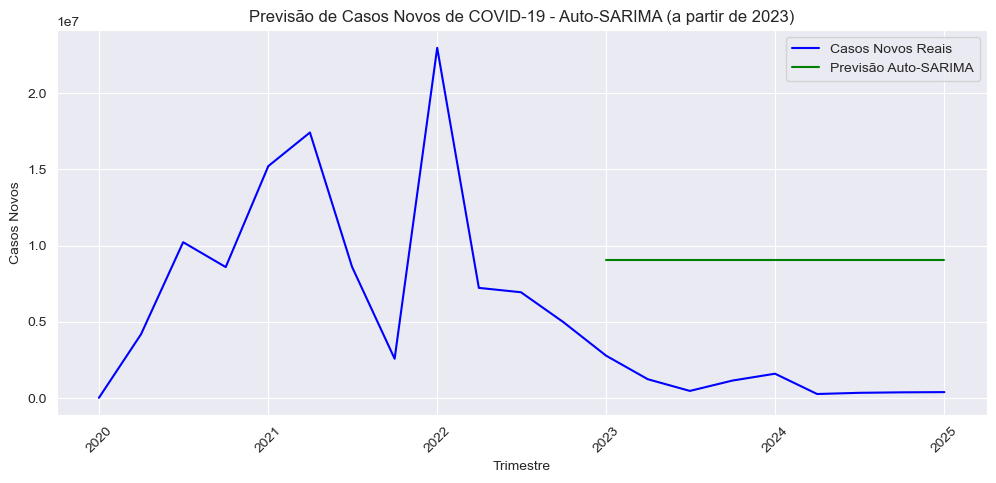

In [24]:
# Auto-SARIMA com m=4 (sazonalidade trimestral)
train = df_trimestral[df_trimestral["trimestre_dt"] < "2023-01-01"]["casosNovos"]
test = df_trimestral[df_trimestral["trimestre_dt"] >= "2023-01-01"]["casosNovos"]
test_index = df_trimestral[df_trimestral["trimestre_dt"] >= "2023-01-01"]["trimestre"]

auto_sarima_model = auto_arima(train, seasonal=True, m=4, D=0, trace=True, stepwise=True, suppress_warnings=True)
print(auto_sarima_model.summary())

forecast_sarima = auto_sarima_model.predict(n_periods=len(test))

# Avaliação
mae_sarima = mean_absolute_error(test, forecast_sarima)
mse_sarima = mean_squared_error(test, forecast_sarima)
rmse_sarima = np.sqrt(mse_sarima)
mape_sarima = np.mean(np.abs((test - forecast_sarima) / test)) * 100

print("\nAvaliação do modelo Auto-SARIMA:")
print(f"MAE: {mae_sarima:.2f}")
print(f"MSE: {mse_sarima:.2f}")
print(f"RMSE: {rmse_sarima:.2f}")
print(f"MAPE: {mape_sarima:.2f}%")

# Plotagem
plt.figure(figsize=(12, 5))
plt.plot(df_trimestral["trimestre"], df_trimestral["casosNovos"], label="Casos Novos Reais", color="blue")
plt.plot(test_index, forecast_sarima, label="Previsão Auto-SARIMA", color="green")
plt.xlabel("Trimestre")
plt.ylabel("Casos Novos")
plt.title("Previsão de Casos Novos de COVID-19 - Auto-SARIMA (a partir de 2023)")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


### 8.5 Modelo de previsão Modelo XGBoost

Melhores Hiperparâmetros: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}

Avaliação do modelo XGBoost:
MAE: 10724589.11
MSE: 155813375851690.66
RMSE: 12482522.82
MAPE: 1774.54%


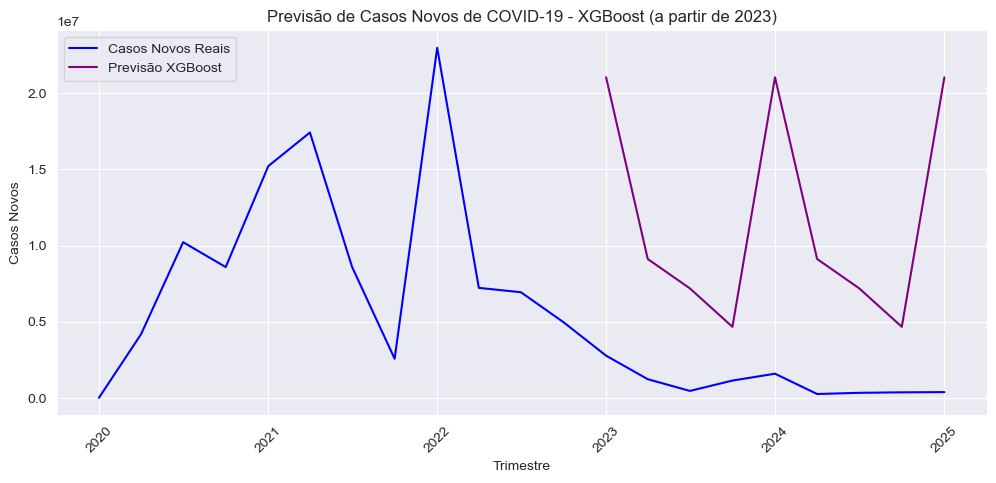

In [25]:
# Features temporais
df_trimestral["trimestre"] = pd.to_datetime(df_trimestral["trimestre"])
df_trimestral["ano"] = df_trimestral["trimestre"].dt.year
df_trimestral["mes"] = df_trimestral["trimestre"].dt.month
df_trimestral["trimestre_num"] = df_trimestral["trimestre"].dt.quarter

features = ["ano", "mes", "trimestre_num"]
X = df_trimestral[features]
y = df_trimestral["casosNovos"]

# Separar treino/teste com base no tempo (a partir de 2023)
train_mask = df_trimestral["trimestre"] < "2023-01-01"
test_mask = ~train_mask
X_train, X_test = X[train_mask], X[test_mask]
y_train, y_test = y[train_mask], y[test_mask]
test_index = df_trimestral[test_mask]["trimestre"]

# Modelo
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", enable_categorical=True, random_state=42)

# Grid Search
param_grid = {
    "n_estimators": [100],
    "learning_rate": [0.1],
    "max_depth": [3],
    "subsample": [1.0],
    "colsample_bytree": [1.0]
}
tscv = TimeSeriesSplit(n_splits=3)
grid_search = GridSearchCV(xgb_model, param_grid, scoring="neg_mean_absolute_error", cv=tscv, n_jobs=-1, verbose=0)
grid_search.fit(X_train, y_train)

best_xgb = grid_search.best_estimator_
print("Melhores Hiperparâmetros:", grid_search.best_params_)

# Previsões
y_pred_xgb = best_xgb.predict(X_test)

# Avaliação
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
mape_xgb = np.mean(np.abs((y_test - y_pred_xgb) / y_test)) * 100

print("\nAvaliação do modelo XGBoost:")
print(f"MAE: {mae_xgb:.2f}")
print(f"MSE: {mse_xgb:.2f}")
print(f"RMSE: {rmse_xgb:.2f}")
print(f"MAPE: {mape_xgb:.2f}%")

# Plotagem
plt.figure(figsize=(12, 5))
plt.plot(df_trimestral["trimestre"], df_trimestral["casosNovos"], label="Casos Novos Reais", color="blue")
plt.plot(test_index, y_pred_xgb, label="Previsão XGBoost", color="purple")
plt.xlabel("Trimestre")
plt.ylabel("Casos Novos")
plt.title("Previsão de Casos Novos de COVID-19 - XGBoost (a partir de 2023)")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


### 8.6 Modelo de previsão Modelo LSTM (Long Short-Term Memory)

Epoch 1/100


C:\Users\leand\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.2715 - val_loss: 0.0016
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.2673 - val_loss: 0.0014
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.2631 - val_loss: 0.0012
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.2589 - val_loss: 0.0010
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.2546 - val_loss: 8.7509e-04
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.2504 - val_loss: 7.5617e-04
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.2461 - val_loss: 6.6531e-04
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.2418 - val_loss: 6.0322e-04
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.2374 - val_loss: 5.7169e-04
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.2331 - val_loss: 5.7292e-04
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.2287 - val_loss: 6.0900e-04
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0

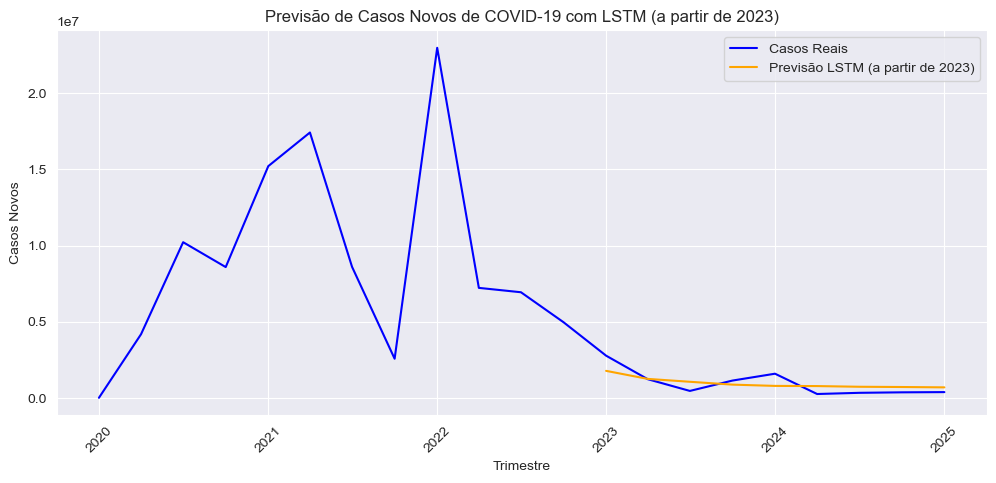

In [26]:
# --- Pré-processamento ---

# Converter trimestre para datetime
df_trimestral["trimestre_dt"] = pd.PeriodIndex(df_trimestral["trimestre"], freq="Q").to_timestamp()

# Ordenar por data
df_trimestral = df_trimestral.sort_values("trimestre_dt")

# Normalizar os dados
scaler = MinMaxScaler()
casos_scaled = scaler.fit_transform(df_trimestral["casosNovos"].values.reshape(-1, 1))

# Criar sequências para LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

# Definir tamanho da janela (ex: 4 trimestres = 1 ano)
SEQ_LENGTH = 4
X, y = create_sequences(casos_scaled, SEQ_LENGTH)

# Separar treino e teste com base na data
train_size = len(df_trimestral[df_trimestral["trimestre_dt"] < "2023-01-01"]) - SEQ_LENGTH
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# --- Modelo LSTM ---

model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(SEQ_LENGTH, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Treinamento com early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=8,
    callbacks=[early_stop],
    verbose=1
)

# --- Previsão ---

y_pred = model.predict(X_test)

# Inverter a normalização
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test)

# Avaliar previsões
mae = mean_absolute_error(y_test_inv, y_pred_inv)
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test_inv - y_pred_inv) / y_test_inv)) * 100

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

# --- Plotar resultados ---

# Gerar rótulos dos trimestres para o eixo X no formato AAAAQN
trimestres = df_trimestral["trimestre"].iloc[SEQ_LENGTH + train_size:]

plt.figure(figsize=(12, 5))
plt.plot(df_trimestral["trimestre"], df_trimestral["casosNovos"], label="Casos Reais", color="blue")
plt.plot(trimestres, y_pred_inv, label="Previsão LSTM (a partir de 2023)", color="orange")
plt.xlabel("Trimestre")
plt.ylabel("Casos Novos")
plt.title("Previsão de Casos Novos de COVID-19 com LSTM (a partir de 2023)")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()
